In [1]:
# Now we will implement a GPT2 model from scratch using PyTorch.
# This is a simplified version and does not include all the optimizations and features of the original GPT2.
import torch
import torch.nn as nn
import torch.nn.functional as F
GPT_CONFIG_124M = {   
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [3]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [4]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [5]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [7]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [8]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
batch =  torch.tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [9]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [10]:
# This is because of weight tying, where the output layer uses the same weights as the input embedding layer.

In [11]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [12]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [13]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [14]:
encoded: [15496, 11, 314, 716] # Example usage of the generate_text_simple function
encoded = torch.tensor([[15496, 11, 314, 716]])  # Example input
generated = generate_text_simple(model, encoded, max_new_tokens=10, context_size=GPT_CONFIG_124M["context_length"])
print("Generated indices:", generated)
print("Generated text:", model.tok_emb.weight[generated].argmax(dim=-1).tolist())

Generated indices: tensor([[15496,    11,   314,   716, 46302,  5748, 32746, 18641, 24436, 21950,
         13748, 50105,  5662,  4266]])
Generated text: [[329, 425, 487, 580, 444, 565, 212, 316, 565, 159, 180, 111, 84, 198]]


In [15]:
# This will produce gibberish text because the model is not trained.

In [16]:
# How do we predict the LLM loss - We use cross-entropy loss, which is a common loss function for classification tasks.
def compute_loss(model, idx):
    # idx is (batch, n_tokens) array of indices in the current context
    logits = model(idx)  # Get the logits for the input indices
    # Shift the indices to the right to create labels
    labels = idx[:, 1:]  # Shifted by one position
    logits = logits[:, :-1, :]  # Remove the last token's logits
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))
    return loss

In [17]:
# We will now evaluate this model on the text dataset.
import os
data_folder = "Data_Preprocessing/data"
raw_texts = []
for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)
    if os.path.isfile(file_path):
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                raw_texts.append(f.read())
        except UnicodeDecodeError:
            print(f"Skipped non-text file: {filename}")

raw_text = "\n".join(raw_texts)


Skipped non-text file: .DS_Store


In [18]:
print("Raw text length:", len(raw_text))
print("First 100 characters of raw text:", raw_text[:100])

Raw text length: 274775
First 100 characters of raw text: 
In my younger and more vulnerable years my father gave me some advice\
that I've been turning over 


In [20]:
import importlib
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [21]:
total_characters = len(raw_text)
print("Total characters in raw text:", total_characters)

total_tokens = len(tokenizer.encode(raw_text))
print("Total tokens in raw text:", total_tokens)

Total characters in raw text: 274775
Total tokens in raw text: 75876


In [22]:
#implementing a dataloader
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, text,tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + 1 + max_length]
            self.input_ids.append(input_chunk)
            self.target_ids.append(target_chunk)

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    
    
    


In [23]:
def create_dataloader(text, batch_size = 4, max_length = 256, stride = 128, shuffle = True, drop_last = True, num_workers = 0):
    
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = TextDataset(text, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    return dataloader


In [24]:
train_ratio = 0.8
train_size = int(len(raw_text) * train_ratio)
train_text = raw_text[:train_size]
test_text = raw_text[train_size:]
train_dataloader = create_dataloader(train_text, batch_size=4, max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"], drop_last=True, shuffle=True, num_workers=0)
test_dataloader = create_dataloader(test_text, batch_size=4, max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"], drop_last=False, shuffle=False, num_workers=0)

In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [40]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = torch.stack(input_batch).to(device)
    target_batch = torch.stack(target_batch).to(device)
    logits = model(input_batch)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_batch.view(-1))
    return loss

In [41]:
def calc_loss_loader(dataloader, model, device, num_batches=None):
    model.eval()
    total_loss = 0.0
    num_batches = num_batches or len(dataloader)
    
    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(dataloader):
            if i >= num_batches:
                break
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
            
    avg_loss = total_loss / num_batches
    return avg_loss

In [42]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    # Calculate loss on the training set
    train_loss = calc_loss_loader(train_dataloader, model, device)
    print(f"Average training loss: {train_loss:.4f}")
    test_loss = calc_loss_loader(test_dataloader, model, device)
    print(f"Average test loss: {test_loss:.4f}")


Average training loss: 11.0000
Average test loss: 10.9991


In [55]:
def evaluate_model(model, train_dataloader, test_dataloader, device):
    model.eval()
    train_loss = 0
    val_loss = 0
    with torch.no_grad():
        for input_batch, target_batch in train_dataloader:
            train_loss += calc_loss_batch(input_batch, target_batch, model, device)
        for input_batch, target_batch in test_dataloader:
            val_loss += calc_loss_batch(input_batch, target_batch, model, device)
    model.train()
    return train_loss, val_loss

In [58]:
# Now we will implement a simple training loop to train the model on the dataset.
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, track_tokens_seen = [], [], []
    token_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            input_batch = torch.stack(input_batch).to(device)
            loss.backward()
            optimizer.step()
            token_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                model.eval()
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(token_seen)
                print(f"Epoch {epoch+1}, Step {global_step}, "
                      f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Tokens Seen: {token_seen:,}")

    
    return train_losses, val_losses, track_tokens_seen

In [63]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

num_epochs = 20
train_losses, val_losses, track_tokens_seen = train_model_simple(
    model, train_dataloader, test_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5
)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")


Epoch 1, Step 0, Train Loss: 124.1960, Val Loss: 35.8273, Tokens Seen: 4,096
Epoch 1, Step 5, Train Loss: 91.2234, Val Loss: 26.6663, Tokens Seen: 24,576
Epoch 1, Step 10, Train Loss: 87.1451, Val Loss: 25.8632, Tokens Seen: 45,056
Epoch 2, Step 15, Train Loss: 86.3001, Val Loss: 25.9666, Tokens Seen: 65,536
Epoch 2, Step 20, Train Loss: 84.3708, Val Loss: 25.4944, Tokens Seen: 86,016
Epoch 2, Step 25, Train Loss: 83.2135, Val Loss: 25.1542, Tokens Seen: 106,496
Epoch 3, Step 30, Train Loss: 82.9197, Val Loss: 24.9479, Tokens Seen: 126,976
Epoch 3, Step 35, Train Loss: 82.1472, Val Loss: 24.9598, Tokens Seen: 147,456
Epoch 3, Step 40, Train Loss: 81.3860, Val Loss: 24.7945, Tokens Seen: 167,936
Epoch 4, Step 45, Train Loss: 80.9666, Val Loss: 24.6994, Tokens Seen: 188,416
Epoch 4, Step 50, Train Loss: 80.4082, Val Loss: 24.5225, Tokens Seen: 208,896
Epoch 4, Step 55, Train Loss: 79.6139, Val Loss: 24.4251, Tokens Seen: 229,376
Epoch 5, Step 60, Train Loss: 78.7850, Val Loss: 24.3194, T

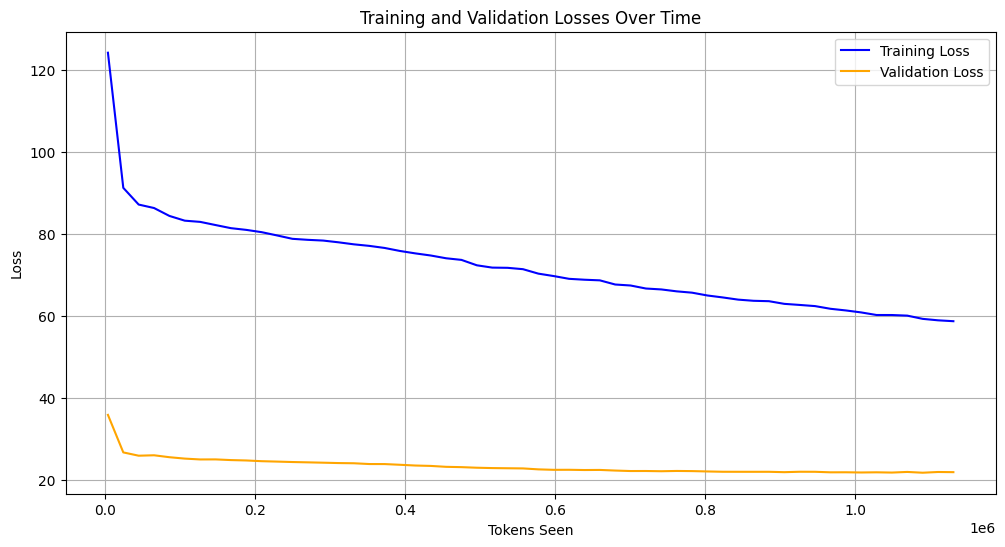

In [64]:
#plot the training and validation losses vs epochs
import matplotlib.pyplot as plt
def plot_losses(train_losses, val_losses, track_tokens_seen):
    # Convert any torch.Tensor entries into Python floats/ints
    xs = [
        x.cpu().item() if isinstance(x, torch.Tensor) else x
        for x in track_tokens_seen
    ]
    ys_train = [
        t.cpu().item() if isinstance(t, torch.Tensor) else t
        for t in train_losses
    ]
    ys_val = [
        v.cpu().item() if isinstance(v, torch.Tensor) else v
        for v in val_losses
    ]

    plt.figure(figsize=(12, 6))
    plt.plot(xs, ys_train, label='Training Loss', color='blue')
    plt.plot(xs, ys_val,   label='Validation Loss', color='orange')
    plt.xlabel('Tokens Seen')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses Over Time')
    plt.legend()
    plt.grid()
    plt.show()
plot_losses(train_losses, val_losses, track_tokens_seen)

In [65]:
torch.save({"model": model.state_dict(), "optimizer": optimizer.state_dict()}, "gpt2_model.pth")
# Load the model
# checkpoint = torch.load("gpt2_model.pth")
# model.load_state_dict(checkpoint["model"])
# optimizer.load_state_dict(checkpoint["optimizer"])
# model.train()


In [66]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    # Calculate loss on the training set
    train_loss = calc_loss_loader(train_dataloader, model, device)
    print(f"Average training loss: {train_loss:.4f}")
    test_loss = calc_loss_loader(test_dataloader, model, device)
    print(f"Average test loss: {test_loss:.4f}")


Average training loss: 4.1551
Average test loss: 5.4460
